In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp alg/em

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from scipy.stats import multivariate_normal


In [ ]:
#| export
class EMGMM:
    def __init__(self, n_components, n_features, low_value=-4.0, high_value=4.0, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = np.random.uniform(low=low_value, high=high_value, size=(self.n_components, n_features))
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])


    def fit(self, X):
        log_likelihood_old = 0

        for iteration in range(self.max_iter):
            print(f"Iteration: {iteration + 1}/{self.max_iter} weights:{self.weights} means:{self.means}, nll: {-log_likelihood_old}")
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._log_likelihood(X)
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
    
    def _e_step(self, X):
        weighted_pdfs = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_pdfs[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        responsibilities = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / X.shape[0]
        self.means = (responsibilities.T @ X) / N_k[:, None]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, None] * diff).T @ diff / N_k[k]

    def _log_likelihood(self, X):
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        return np.sum(np.log(log_likelihood))
    
    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


(300, 2)
Iteration: 1/100 weights:[0.5 0.5] means:[[1.11159508 2.07228676]
 [1.79282663 1.09785264]], nll: 0
Iteration: 2/100 weights:[0.39426786 0.60573214] means:[[-0.34574078  0.55312795]
 [-0.59300877 -1.06620943]], nll: 1195.4210066663243
Iteration: 3/100 weights:[0.40582083 0.59417917] means:[[-0.26199537  0.60296466]
 [-0.65501415 -1.1317333 ]], nll: 1191.9891364997236
Iteration: 4/100 weights:[0.41924442 0.58075558] means:[[-0.14930978  0.68639364]
 [-0.74544553 -1.23205608]], nll: 1189.552724418832
Iteration: 5/100 weights:[0.43374999 0.56625001] means:[[-0.00963718  0.79016518]
 [-0.86770651 -1.36069027]], nll: 1186.4791330346018
Iteration: 6/100 weights:[0.44946803 0.55053197] means:[[ 0.16123585  0.91324826]
 [-1.03170993 -1.52258665]], nll: 1180.9784143512288
Iteration: 7/100 weights:[0.46644327 0.53355673] means:[[ 0.37214044  1.05855484]
 [-1.25403977 -1.72711257]], nll: 1168.4084971459647
Iteration: 8/100 weights:[0.48200406 0.51799594] means:[[ 0.63639739  1.22992333]


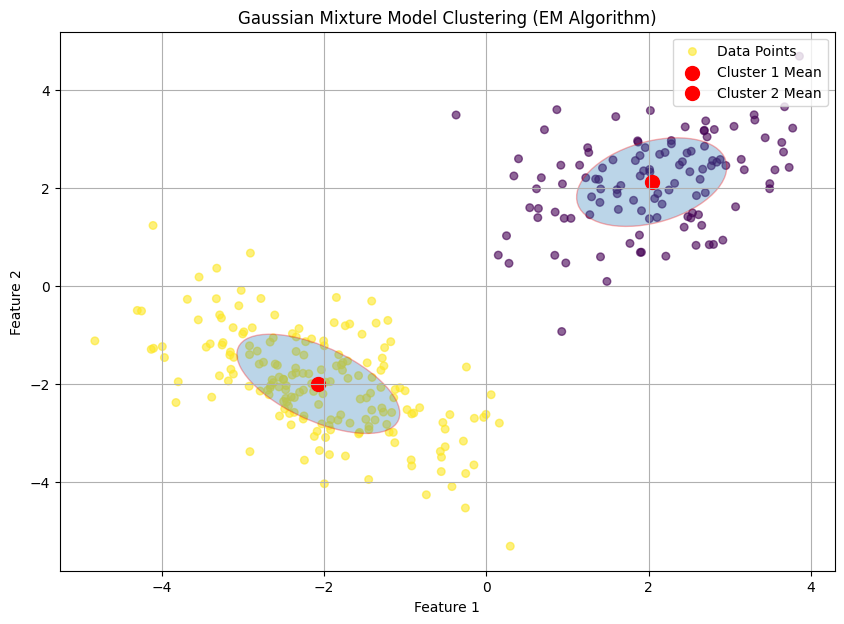

weights [0.38334526 0.61665474]
Means:
[[ 2.03743201  2.11072866]
 [-2.07013545 -2.00581375]]
Covariances:
[[[ 0.85607018  0.28454685]
  [ 0.28454685  0.81682196]]

 [[ 1.0076269  -0.60642494]
  [-0.60642494  1.0256162 ]]]
Cluster Assignments:
[1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0
 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0
 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0
 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0
 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1
 1 0 0 1]


In [ ]:
from eval_llm_coding.data import generate_mixed_gaussian_data
from eval_llm_coding.plot import plot_2d_mix_guassian

# Generate synthetic data
np.random.seed(42)

means = np.array([[2, 2], [-2, -2]])
covariances = [np.array([[1, 0.5], [0.5, 1]]),
               np.array([[1, -0.5], [-0.5, 1]])
            ]
weights = [0.4, 0.6] 
n_samples = 300

X, _ = generate_mixed_gaussian_data(n_samples, means, covariances, weights)
print(X.shape)

# Apply EM algorithm
n_components, n_features = means.shape
em_gmm = EMGMM(n_components=n_components, n_features=n_features, max_iter=100)
em_gmm.fit(X)
predictions = em_gmm.predict(X)

# Visualize results
plot_2d_mix_guassian(X, em_gmm.means, em_gmm.covariances, predictions)


# Display results
print(f"weights {em_gmm.weights}")
print("Means:")
print(em_gmm.means)
print("Covariances:")
print(em_gmm.covariances)
print("Cluster Assignments:")
print(predictions)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()